# Task 2

In [1]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image
from IPython.display import display
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import random
from sklearn.linear_model import LassoCV

c:\Users\HP\Programming\XAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## 1) Calculate the predictions for selected observations

First image: siberian husky

Probability:  68.0202066898346
Label:  Eskimo dog, husky


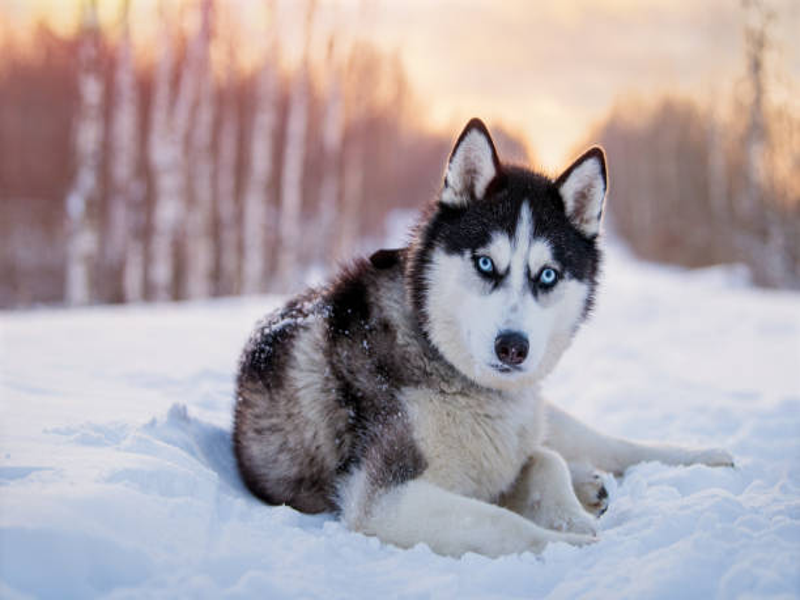

In [68]:
image1 = Image.open("husky.jpg").resize([800,600])
inputs1 = image_processor(image1, return_tensors="pt")

with torch.no_grad():
    logits1 = model(**inputs1).logits

# model predicts one of the 1000 ImageNet classes
predicted_label1 = logits1.argmax(-1).item()

print("Probability: ", 100 * torch.max(torch.softmax(logits1, dim = -1)).item())
print("Label: ", model.config.id2label[predicted_label1])

display(image1)

Second image: wolf

Probability:  45.21810710430145
Label:  timber wolf, grey wolf, gray wolf, Canis lupus


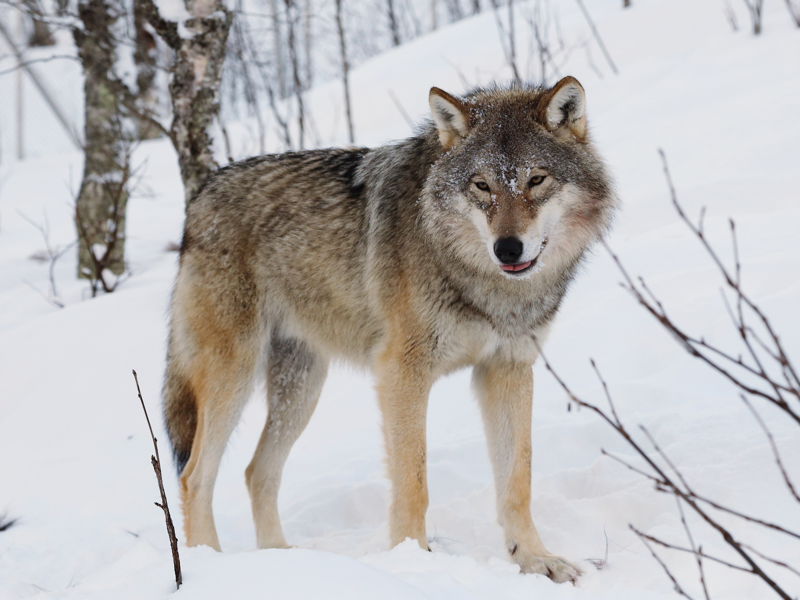

In [67]:
image2 = Image.open("wolf.jpg").resize([800,600])
inputs2 = image_processor(image2, return_tensors="pt")

with torch.no_grad():
    logits2 = model(**inputs2).logits

# model predicts one of the 1000 ImageNet classes
predicted_label2 = logits2.argmax(-1).item()

print("Probability: ", 100 * torch.max(torch.softmax(logits2, dim = -1)).item())
print("Label: ", model.config.id2label[predicted_label2])

display(image2)

## 2) calculate 20-50 regions for a given image. 

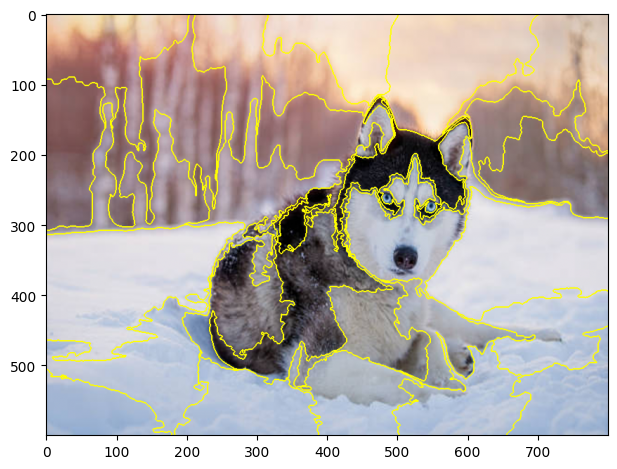

In [ ]:
segments_slic1 = slic(np.array(image1), n_segments=30, compactness=10, sigma=1, start_label=1)

plt.imshow(mark_boundaries(np.array(image1), segments_slic1))
plt.tight_layout()
plt.show()

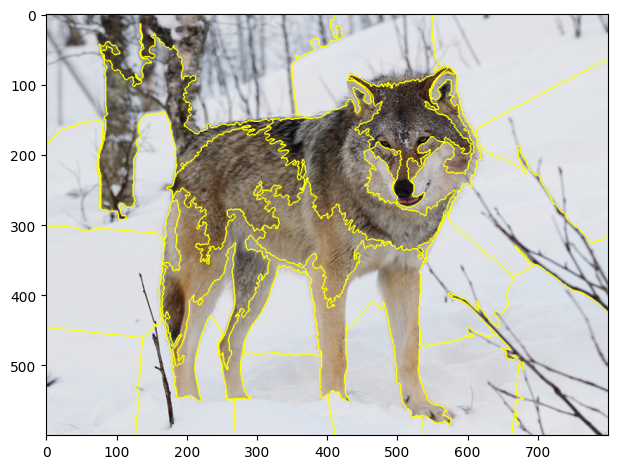

In [72]:
segments_slic2 = slic(np.array(image2), n_segments=30, compactness=10, sigma=1, start_label=1)

plt.imshow(mark_boundaries(np.array(image2), segments_slic2))
plt.tight_layout()
plt.show()

## 3) Generate N subimages with randomly selected parts of an image. Calculate predictions for these parts.

Example of image with 10 chosen superpixels

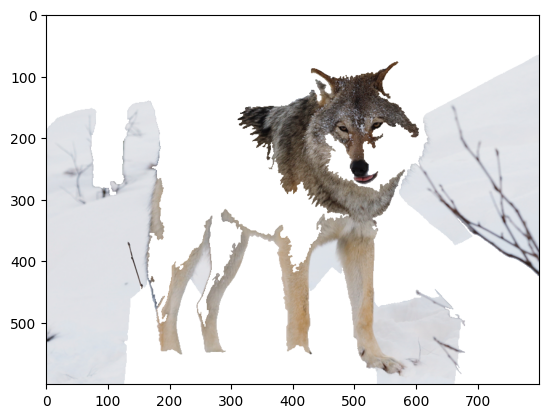

In [102]:
num_segments_to_keep = 10
all_segments2 = np.unique(segments_slic2)
selected_segments = random.sample(list(all_segments2), num_segments_to_keep)


masked_image = image2.copy()
mask = np.isin(segments_slic2, selected_segments)
image = image2 * np.dstack([mask]*3) + (1 - np.dstack([mask]*3)) * 255

plt.imshow(image)

300 random images with 10 chosen superpixels

In [ ]:
labels = []
probs = []
segments = np.zeros((300, 30))

for i in range(300):
    num_segments_to_keep = 10
    all_segments2 = np.unique(segments_slic2)
    selected_segments = random.sample(list(all_segments2), num_segments_to_keep)

    segments[i][selected_segments] = 1 # chosen superpixels for every image

    masked_image = image2.copy()
    mask = np.isin(segments_slic2, selected_segments)
    image = image2 * np.dstack([mask]*3) + (1 - np.dstack([mask]*3)) * 255

    inputs1 = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        logits1 = model(**inputs1).logits

    # model predicts one of the 1000 ImageNet classes
    predicted_label1 = logits1.argmax(-1).item()
    label = model.config.id2label[predicted_label1]

    labels.append(label) # name of the predicted class
    probs.append(predicted_label1) # probabilities

## 4) Lime explanations

Lasso explanation on 30 dimensional space (10 ones, 20 zeros) of superpixels with 300 samples

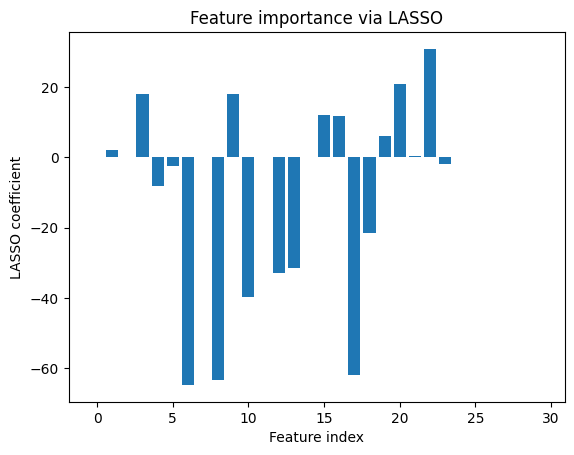

In [151]:
lasso = LassoCV(cv=5, random_state=42).fit(segments, np.array(probs))

plt.bar(range(segments.shape[1]), lasso.coef_)
plt.xlabel("Feature index")
plt.ylabel("LASSO coefficient")
plt.title("Feature importance via LASSO")
plt.show()

Text(0.5, 1.0, '3 most important superpixels')

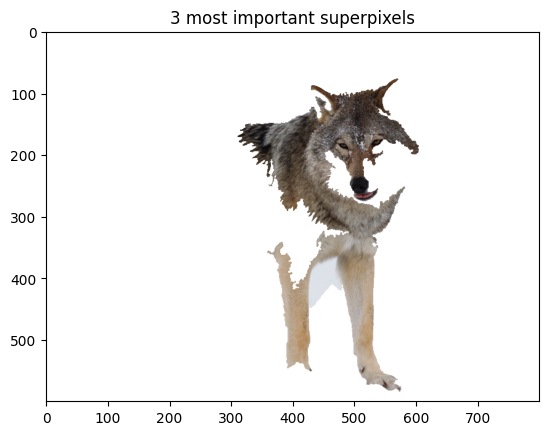

In [160]:
masked_image = image2.copy()
most_important = np.argpartition(abs(lasso.coef_), 4)[-3:]
mask = np.isin(segments_slic2, most_important)
image = image2 * np.dstack([mask]*3) + (1 - np.dstack([mask]*3)) * 255

plt.imshow(image)
plt.title("3 most important superpixels")